In [12]:
using Kinbiont
using DifferentialEquations
using CSV
using Plots
using StatsBase
using AbstractTrees
using MLJDecisionTreeInterface
using TreeRecipe
using DecisionTree
using Distributions
using Random

┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ KinbiontPlots
│  └─ Kinbiont
└ @ Base.Precompilation precompilation.jl:650
[ Info: Precompiling Kinbiont [3b7c519f-be5e-4159-a208-6486ce96bb37] (cache misses: include_dependency fsize change (2), wrong dep version loaded (6))
┌ Warning: Circular dependency detected.
│ Precompilation will be skipped for dependencies in this cycle:
│  ┌ KinbiontPlots
│  └─ Kinbiont
└ @ Base.Precompilation precompilation.jl:650
[ Info: Precompiling UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970] (cache misses: wrong dep version loaded (6), incompatible header (2))


In this example, we will use Kinbiont to generate data about a simple community of tree species (N_1, N_2, and N_3). 
We suppose that the user can only measure the total biomass of the community (N_1 + N_2 + N_3)
but they can vary the initial composition of the community. By fitting the biomass with a single empirical model, 
we apply a decision tree algorithm using the initial composition of the community as features and 
the parameters of the model as the quantity to predict. We show how we can decompose the effect 
of the initial population size on the behavior of the full population.

In [13]:
# We initialize the array for the results
results_fit = Any

Any

In [14]:
# Tree species ODE model: they compete for the same resource u[4], and u[3] is able to predate on u[1]
function model_1(du, u, param, t)
    # Define the ODEs
    du[1] = param[1] * u[1] * u[4] - param[4] * u[3] * u[1] 
    du[2] = param[2] * u[2] * u[4]
    du[3] = param[3] * u[2] * u[4] + param[4] * u[3] * u[1]
    du[4] = (-param[1] * u[1] - param[2] * u[2] + -param[3] * u[3]) * u[4]
end

model_1 (generic function with 1 method)

In [15]:
# Parameters [1/yield_1, 1/yield_2, 1/yield_3, predation (3->1)]
param = [0.05, 0.02, 0.03, 0.03]

4-element Vector{Float64}:
 0.05
 0.02
 0.03
 0.03

In [16]:
# We define the noise to add to the simulated data
noise_value = 0.01

0.01

In [17]:
# We declare the ODE model, its upper/lower bounds, and initial guess
# Parameters to fit
ODE_models = "HPM"
ub_1 = [0.5, 5.1, 16.0]
lb_1 = [0.0001, 0.000001, 0.00]
p1_guess = lb_1 .+ (ub_1 .- lb_1) ./ 2

3-element Vector{Float64}:
 0.25005
 2.5500005
 8.0

In [18]:
# We generate a random matrix of features (i.e., initial conditions)
# Define the dimensions of the matrix
cols = 3
n_experiment = 150

150

In [19]:
# Generate a random matrix with 0s and 0.1s
random_matrix = rand([0, 0.1], n_experiment, cols)
labels = string.(1:1:n_experiment)
random_matrix = hcat(labels, random_matrix)
random_matrix

150×4 Matrix{Any}:
 "1"    0.1  0.1  0.1
 "2"    0.1  0.0  0.0
 "3"    0.0  0.1  0.0
 "4"    0.0  0.0  0.1
 "5"    0.1  0.0  0.0
 "6"    0.1  0.0  0.1
 "7"    0.0  0.0  0.1
 "8"    0.0  0.1  0.0
 "9"    0.0  0.1  0.1
 "10"   0.0  0.0  0.0
 "11"   0.0  0.0  0.1
 "12"   0.0  0.1  0.1
 "13"   0.1  0.0  0.0
 ⋮                
 "139"  0.0  0.1  0.1
 "140"  0.0  0.1  0.0
 "141"  0.0  0.0  0.1
 "142"  0.1  0.1  0.1
 "143"  0.1  0.0  0.0
 "144"  0.1  0.0  0.1
 "145"  0.0  0.0  0.0
 "146"  0.1  0.0  0.1
 "147"  0.1  0.0  0.1
 "148"  0.1  0.1  0.1
 "149"  0.1  0.1  0.0
 "150"  0.0  0.1  0.0

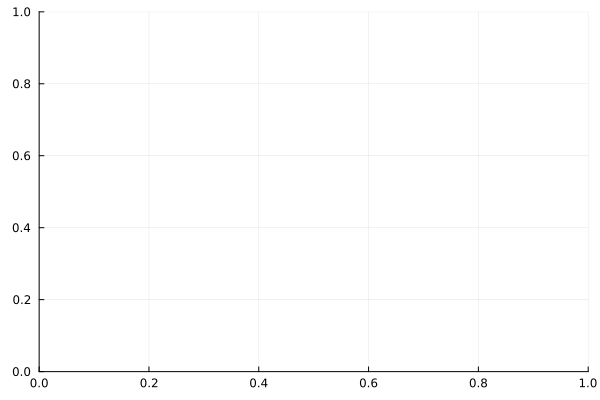

In [20]:
# Defining the parameter values for the simulation 
t_min = 0.0
t_max = 200.0
delta_t = 8.0
noise_value = 0.05
blank_value = 0.08
plot(0, 0)

In [ ]:
for f in 1:size(random_matrix)[1]

    # Defining the initial condition with different community compositions
    u0 = random_matrix[f, 2:4]
    u0 = push!(u0, 5.0)
    u0 = convert.(Float64, u0)

    # Calling the simulation function
    Simulation = ODEs_system_sim(
        model_1, # ODE system 
        u0, # Initial conditions
        t_min, # Start time of the simulation
        t_max, # Final time of the simulation
        delta_t, # Delta t for Poisson approximation
        param; # Parameters of the ODE model
    )

    # Plotting scatterplot of data without noise

    # Adding uniform random noise
    noise_uniform = rand(Uniform(-noise_value, noise_value), length(Simulation.t))

    data_t = reduce(hcat, Simulation.t)
    data_o = reduce(hcat, Simulation.u)
    data_o = data_o[1:3, :]

    data_o = sum(data_o, dims=1)

    data_OD = vcat(data_t, data_o)
    data_OD[2, :] = data_OD[2, :] .+ noise_uniform .+ blank_value
    # Plotting scatterplot of data with noise

    display(Plots.scatter!(data_OD[1, :], data_OD[2, :], xlabel="Time", ylabel="Arb. Units", label=nothing, color=:red, markersize=2, size=(300, 300)))

    # Fitting with Kinbiont
    results_ODE_fit = fitting_one_well_ODE_constrained(
        data_OD,
        string(random_matrix[f, 1]),
        "test_ODE",
        ODE_models,
        p1_guess;
        remove_negative_value=true,
        pt_avg=2,
        lb=lb_1,
        ub=ub_1
    )

    display(Plots.plot!(results_ODE_fit[4], results_ODE_fit[3], xlabel="Time", ylabel="Arb. Units", label=nothing, color=:red, markersize=2, size=(300, 300)))

    # Storing results
    if f == 1
        results_fit = results_ODE_fit[2]
    else
        results_fit = hcat(results_fit, results_ODE_fit[2])
    end
end

Parameters and feature names for the decision tree

In [22]:
n_folds = 10
feature_names = ["CI_1", "CI_2", "CI_3"]
depth = -1 
seed = Random.seed!(1234)
feature_matrix = vcat(["label" "CI_1" "CI_2" "CI_3"], random_matrix)

151×4 Matrix{Any}:
 "label"   "CI_1"   "CI_2"   "CI_3"
 "1"      0.1      0.1      0.1
 "2"      0.1      0.0      0.0
 "3"      0.0      0.1      0.0
 "4"      0.0      0.0      0.1
 "5"      0.1      0.0      0.0
 "6"      0.1      0.0      0.1
 "7"      0.0      0.0      0.1
 "8"      0.0      0.1      0.0
 "9"      0.0      0.1      0.1
 "10"     0.0      0.0      0.0
 "11"     0.0      0.0      0.1
 "12"     0.0      0.1      0.1
 ⋮                          
 "139"    0.0      0.1      0.1
 "140"    0.0      0.1      0.0
 "141"    0.0      0.0      0.1
 "142"    0.1      0.1      0.1
 "143"    0.1      0.0      0.0
 "144"    0.1      0.0      0.1
 "145"    0.0      0.0      0.0
 "146"    0.1      0.0      0.1
 "147"    0.1      0.0      0.1
 "148"    0.1      0.1      0.1
 "149"    0.1      0.1      0.0
 "150"    0.0      0.1      0.0

In [23]:
# Calling the decision tree regression for the 6th row of results_fit. It represents the saturation value N_max
dt_gr = Kinbiont.downstream_decision_tree_regression(results_fit,
    feature_matrix,
    6; # Row to learn
    do_pruning=false,
    verbose=true,
    do_cross_validation=true,
    max_depth=depth,
    n_folds_cv=n_folds,
    seed=seed
)


Fold 1
Mean Squared Error:     0.28828901394594614
Correlation Coeff:      0.9918011811093379
Coeff of Determination: 0.9499169336191357

Fold 2
Mean Squared Error:     16.881398919759775
Correlation Coeff:      0.11152774044755409
Coeff of Determination: -0.3129530967921006

Fold 3
Mean Squared Error:     0.08312218453542325
Correlation Coeff:      0.9960810341310768
Coeff of Determination: 0.9764122003053882

Fold 4
Mean Squared Error:     0.2086092985137085
Correlation Coeff:      0.9918063374614365
Coeff of Determination: 0.9633007027636276

Fold 5
Mean Squared Error:     0.03892283968217542
Correlation Coeff:      0.9966031726843717
Coeff of Determination: 0.9887875896920459

Fold 6
Mean Squared Error:     0.22860999373653285
Correlation Coeff:      0.9803323307862083
Coeff of Determination: 0.9589375839890849

Fold 7
Mean Squared Error:     0.0005998446319161581
Correlation Coeff:      0.9999927218192213
Coeff of Determination: 0.9997765465007034

Fold 8
Mean Squared Error:     

(Decision Tree
Leaves: 8
Depth:  3, [1.761327606065898, 1.8756352314212685, 0.03022308158754522], [1.0, 3.0, 3.0], [0.9499169336191357, -0.3129530967921006, 0.9764122003053882, 0.9633007027636276, 0.9887875896920459, 0.9589375839890849, 0.9997765465007034, 0.9995459483004673, 0.9825433838861398, 0.9739506587729307], Any["values" 1.0 … 8.0 8.0; "cluster" 0.0951297498972939 … 4.922789926399379 4.923622702071979])

In [24]:
# Wrap the decision tree model for visualization
wt = DecisionTree.wrap(dt_gr[1], (featurenames=feature_names,))

CI_1 < 0.05
├─ CI_2 < 0.05
│  ├─ CI_3 < 0.05
│  │  ├─ 0.8122179648888594 (0/22)
│  │  └─ 0.2447000358452606 (0/18)
│  └─ CI_3 < 0.05
│     ├─ 4.521996708985909 (0/15)
│     └─ 4.287279813493269 (0/22)
└─ CI_3 < 0.05
   ├─ CI_2 < 0.05
   │  ├─ 5.173272803257394 (0/24)
   │  └─ 5.107217024592211 (0/17)
   └─ CI_2 < 0.05
      ├─ 4.936398704832175 (0/13)
      └─ 4.922184108753684 (0/19)


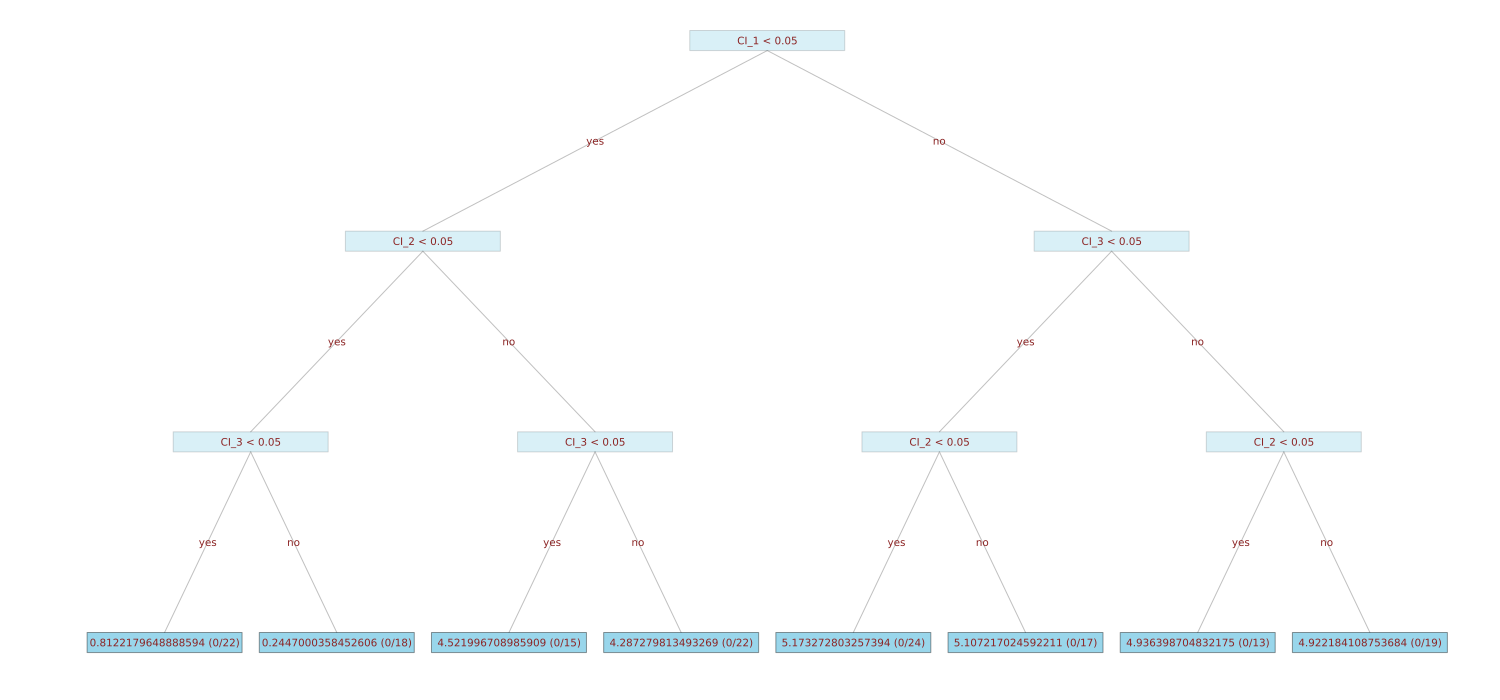

In [25]:
# Plot the decision tree
p2 = Plots.plot(wt, 0.9, 0.2; size=(1500, 700), connect_labels=["yes", "no"])

In [26]:
# Calling the decision tree regression for the 7th row of results_fit. It represents the maximum per capita growth rate
 dt_gr = Kinbiont.downstream_decision_tree_regression(results_fit,
    feature_matrix,
    7; # Row to learn
    do_pruning=false,
    verbose=true,
    do_cross_validation=true,
    max_depth=depth,
    n_folds_cv=n_folds,
    seed=seed
)


Fold 1
Mean Squared Error:     5.001170330100539e-7
Correlation Coeff:      0.9991398790409487
Coeff of Determination: 0.9972766094139542

Fold 2
Mean Squared Error:     5.328413810204076e-6
Correlation Coeff:      0.9960125928013683
Coeff of Determination: 0.9906327379828419

Fold 3
Mean Squared Error:     1.5012087343874325e-6
Correlation Coeff:      0.9991364030990951
Coeff of Determination: 0.9975484808358628

Fold 4
Mean Squared Error:     1.3757980588495526e-6
Correlation Coeff:      0.998475598606522
Coeff of Determination: 0.9969299549051012

Fold 5
Mean Squared Error:     1.438814696658746e-6
Correlation Coeff:      0.9992111972168639
Coeff of Determination: 0.9973033260127803

Fold 6
Mean Squared Error:     1.6861590498478396e-6
Correlation Coeff:      0.9984121809494196
Coeff of Determination: 0.9963175816013158

Fold 7
Mean Squared Error:     1.055803592051565e-6
Correlation Coeff:      0.9987520480346288
Coeff of Determination: 0.9971339185156628

Fold 8
Mean Squared Erro

(Decision Tree
Leaves: 8
Depth:  3, [0.00032606200089488883, 0.00012077879676677233, 5.046150549354459e-6], [2.0, 1.0, 4.0], [0.9972766094139542, 0.9906327379828419, 0.9975484808358628, 0.9969299549051012, 0.9973033260127803, 0.9963175816013158, 0.9971339185156628, 0.9691914631254808, 0.9987246288372961, 0.995030468929508], Any["values" 1.0 … 8.0 8.0; "cluster" 1.0438558551492693e-17 … 0.03958823576756745 0.03904828673404675])

In [27]:
# Wrap the decision tree model for visualization
wt = DecisionTree.wrap(dt_gr[1], (featurenames=feature_names,))

CI_2 < 0.05
├─ CI_1 < 0.05
│  ├─ CI_3 < 0.05
│  │  ├─ 0.0021745711218299694 (0/22)
│  │  └─ 0.0005575589667581154 (0/18)
│  └─ CI_3 < 0.05
│     ├─ 0.05181865485947207 (0/24)
│     └─ 0.04770136161223856 (0/13)
└─ CI_1 < 0.05
   ├─ CI_3 < 0.05
   │  ├─ 0.05770043951396168 (0/15)
   │  └─ 0.05006831167174764 (0/22)
   └─ CI_3 < 0.05
      ├─ 0.04201205315278613 (0/17)
      └─ 0.039247593564777215 (0/19)


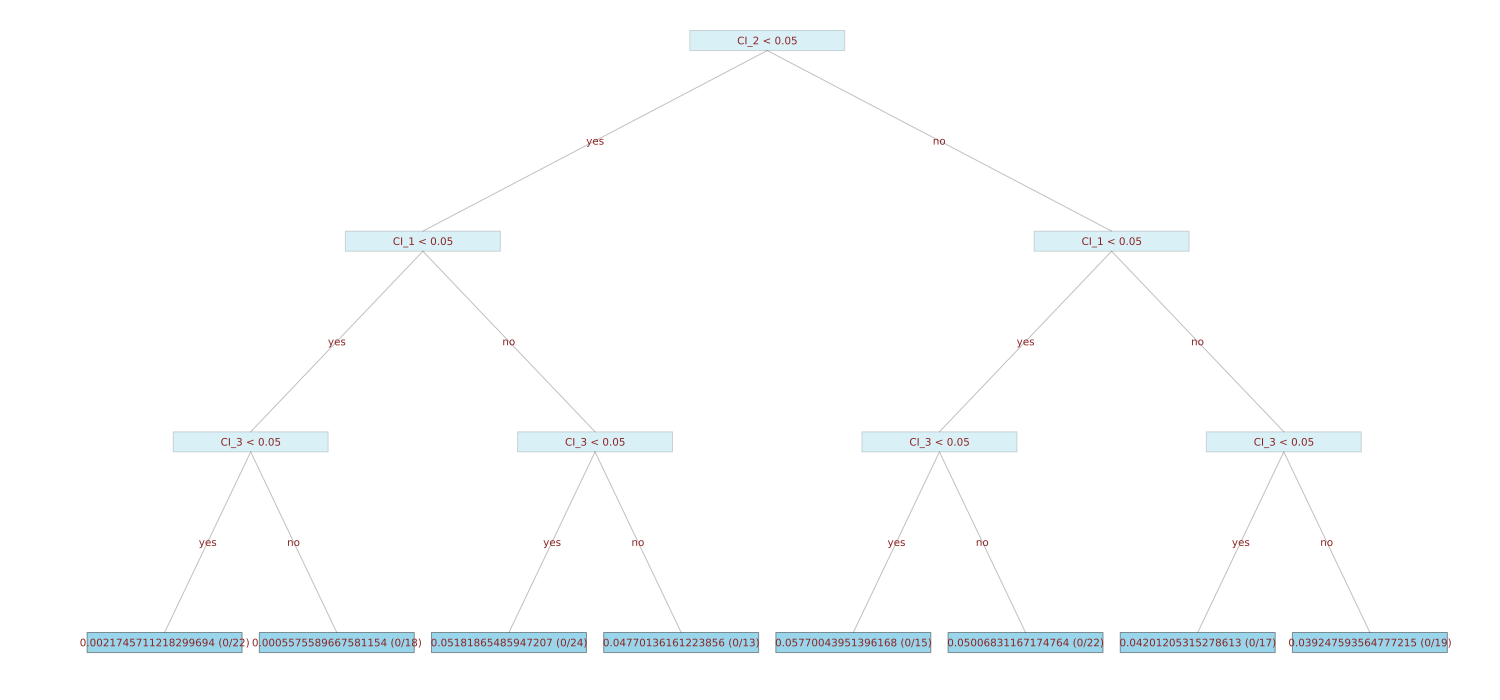

In [28]:
# Plot the decision tree
p2 = Plots.plot(wt, 0.9, 0.2; size=(1500, 700), connect_labels=["yes", "no"])